In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import cProfile
from propagation import laser
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from propagation import laserv2
from numpy.fft import fftfreq, fftshift, fft2

%load_ext line_profiler
from line_profiler import LineProfiler
%load_ext memory_profiler
#import timeit

def do_profile(follow=[]):
    def inner(func):
        def profiled_func(*args, **kwargs):
            try:
                profiler = LineProfiler()
                profiler.add_function(func)
                for f in follow:
                    profiler.add_function(f)
                profiler.enable_by_count()
                return func(*args, **kwargs)
            finally:
                profiler.print_stats()
        return profiled_func
    return inner

path = '/media/robert/Data_Storage/Data/Optimization/fourier_prop/'
if not os.path.exists(path):
    os.makedirs(path)

In [2]:
Nx = 2**8
X = 100
x = np.linspace(-X/2, X/2, Nx, False)
Ny = 2**8
Y = 100
y = np.linspace(-Y/2, Y/2, Ny, False)

Nz = 2**8
Z = 100
z = np.linspace(0, Z, Nz)

w0 = 5
zR = np.pi * w0**2
wZ = w0 * np.sqrt(1 + (Z/zR)**2)
E = np.array(np.exp(-(np.reshape(x-10, (Nx, 1))**2 + np.reshape(y, (1, Ny))**2) / w0**2), dtype='complex128')
EE = (w0 / wZ) * np.exp(-(x-10)**2 / wZ**2)

cProfile.run('laser.fourier_prop2(E, x, y, z, 0.8)')

         155 function calls in 1.958 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.006    0.006    1.958    1.958 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 _methods.py:37(_any)
        2    0.000    0.000    0.001    0.001 fftpack.py:102(fft)
        2    0.124    0.062    0.640    0.320 fftpack.py:198(ifft)
        4    0.000    0.000    0.371    0.093 fftpack.py:47(_raw_fft)
        2    0.000    0.000    0.000    0.000 fftpack.py:611(_cook_nd_args)
        2    0.034    0.017    0.675    0.338 fftpack.py:630(_raw_fftnd)
        1    0.000    0.000    0.001    0.001 fftpack.py:834(fft2)
        1    0.000    0.000    0.674    0.674 fftpack.py:924(ifft2)
        4    0.000    0.000    0.000    0.000 fftpack.py:95(_unitary)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:138(reshape)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:1866(any)
        3    0.0

In [3]:
@do_profile(follow=[laser.fourier_prop2])
def test(E, x, y, z):
    laser.fourier_prop2(E, x, y, z, 0.8)
    
result = test(E, x, y, z)
# I split the function up to see which part was slow, it ends up close to two thirds of the computation is spent
# calculating the np.exp(...) part, potentially can be spead up

Timer unit: 1e-06 s

Total time: 1.65731 s
File: ../../python/propagation/laser.py
Function: fourier_prop2 at line 131

Line #      Hits         Time  Per Hit   % Time  Line Contents
   131                                           def fourier_prop2(E, x, y, z, lam, n=1):
   132                                               """ Propagates an electromagnetic wave from a 2D boundary.
   133                                           
   134                                               Uses the Rayleigh-Sommerfeld transfer function to propagate an
   135                                               electromagnetic wave from a 2D boundary. The calculation assumes a
   136                                               homogeneous index of refraction in the region of propagation.
   137                                           
   138                                               Parameters
   139                                               ----------
   140                              

In [4]:
#import pyximport; pyximport.install()
#from propagation import laserv2
cProfile.run('laserv2.fourier_prop2(E, x, y, z, 0.8, path=path)')

         77949 function calls in 1.060 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      256    0.000    0.000    0.001    0.000 <frozen importlib._bootstrap>:989(_handle_fromlist)
        1    0.000    0.000    1.060    1.060 <string>:1(<module>)
     5120    0.003    0.000    0.005    0.000 <string>:12(__new__)
        2    0.000    0.000    0.000    0.000 _utils.py:311(_compute_array_shapes)
        2    0.000    0.000    0.000    0.000 _utils.py:360(_cook_nd_args)
        2    0.191    0.095    0.191    0.095 _utils.py:76(_Xfftn)
        1    0.000    0.000    0.101    0.101 builders.py:307(fft2)
        1    0.000    0.000    0.089    0.089 builders.py:326(ifft2)
      256    0.000    0.000    0.000    0.000 format.py:171(_check_version)
      256    0.001    0.000    0.001    0.000 format.py:176(magic)
      256    0.001    0.000    0.001    0.000 format.py:223(dtype_to_descr)
      256    0.001    0.000    0.002 

In [5]:
@do_profile(follow=[laserv2.fourier_prop2])
def test(E, x, y, z, path):
    laserv2.fourier_prop2(E, x, y, z, 0.8, path=path)
    
result = test(E, x, y, z, path)

Timer unit: 1e-06 s

Total time: 0.815891 s
File: <ipython-input-5-3a95d825da8e>
Function: test at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           @do_profile(follow=[laserv2.fourier_prop2])
     2                                           def test(E, x, y, z, path):
     3         1       815891 815891.0    100.0      laserv2.fourier_prop2(E, x, y, z, 0.8, path=path)

Total time: 0.815168 s

Could not find file propagation/laserv2.pyx
Are you sure you are running this program from the same directory
that you ran the profiler from?
Continuing without the function's contents.

Line #      Hits         Time  Per Hit   % Time  Line Contents
    46                                           
    47                                           
    48                                           
    49                                           
    50                                           
    51                          

In [6]:
# Lets compare speed for larger grid sizes
Nx = 2**10
X = 100
x = np.linspace(-X/2, X/2, Nx, False)
Ny = 2**10
Y = 100
y = np.linspace(-Y/2, Y/2, Ny, False)

Nz = 2**8
Z = 100
z = np.linspace(0, Z, Nz)

w0 = 5
zR = np.pi * w0**2
wZ = w0 * np.sqrt(1 + (Z/zR)**2)
E = np.array(np.exp(-(np.reshape(x-10, (Nx, 1))**2 + np.reshape(y, (1, Ny))**2) / w0**2), dtype='complex128')
EE = (w0 / wZ) * np.exp(-(x-10)**2 / wZ**2)

#%timeit laser.fourier_prop2(E, x, y, z, 0.8)
#%memit laser.fourier_prop2(E, x, y, z, 0.8)

%timeit laserv2.fourier_prop2(E, x, y, z, 0.8, path=path)
%memit laserv2.fourier_prop2(E, x, y, z, 0.8, path=path)

@do_profile(follow=[laserv2.fourier_prop2])
def test(E, x, y, z, path):
    laserv2.fourier_prop2(E, x, y, z, 0.8, path=path)
    
result = test(E, x, y, z, path)

1 loop, best of 3: 11 s per loop
peak memory: 173.18 MiB, increment: 64.79 MiB
Timer unit: 1e-06 s

Total time: 11.7439 s
File: <ipython-input-6-e9fbf0bfde46>
Function: test at line 25

Line #      Hits         Time  Per Hit   % Time  Line Contents
    25                                           @do_profile(follow=[laserv2.fourier_prop2])
    26                                           def test(E, x, y, z, path):
    27         1     11743858 11743858.0    100.0      laserv2.fourier_prop2(E, x, y, z, 0.8, path=path)

Total time: 11.7427 s

Could not find file propagation/laserv2.pyx
Are you sure you are running this program from the same directory
that you ran the profiler from?
Continuing without the function's contents.

Line #      Hits         Time  Per Hit   % Time  Line Contents
    46                                           
    47                                           
    48                                           
    49                                           
  

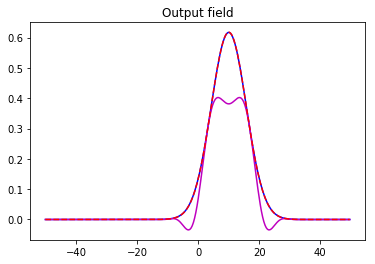

In [7]:
Nx = 2**8
X = 100
x = np.linspace(-X/2, X/2, Nx, False)
Ny = 2**8
Y = 100
y = np.linspace(-Y/2, Y/2, Ny, False)

Nz = 2**8
Z = 100
z = np.linspace(0, Z, Nz)

w0 = 5
zR = np.pi * w0**2
wZ = w0 * np.sqrt(1 + (Z/zR)**2)
E = np.array(np.exp(-(np.reshape(x-10, (Nx, 1))**2 + np.reshape(y, (1, Ny))**2) / w0**2), dtype='complex128')
EE = (w0 / wZ) * np.exp(-(x-10)**2 / wZ**2)

dx = X / (Nx-1)
fx = fftshift(fftfreq(Nx, dx))

e = laserv2.fourier_prop2(E, x, y, z, 1, path=path)

plt.plot(x, abs(e[:,int(Ny/2)]), 'b', x, e[:,int(Ny/2)].real, 'm', x, EE, 'r--')
plt.title('Output field')
plt.show()

In [ ]:
# Test to see if the test case is okay